In [14]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class SpeciesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row['species'], row['imageFile'])
        image = Image.open(img_path).convert('RGB')
        label = row['species_id']
        if self.transform:
            image = self.transform(image)
        return image, label


In [15]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Common transform pipeline (can be customized further)
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = SpeciesDataset("/Users/mdshayan/Desktop/invasive-species-classifier/data/splits/train.csv", "/Users/mdshayan/Desktop/invasive-species-classifier/data/preprocessed", transform=common_transform)
val_dataset   = SpeciesDataset("/Users/mdshayan/Desktop/invasive-species-classifier/data/splits/val.csv", "/Users/mdshayan/Desktop/invasive-species-classifier/data/preprocessed", transform=common_transform)
test_dataset  = SpeciesDataset("/Users/mdshayan/Desktop/invasive-species-classifier/data/splits/test.csv", "/Users/mdshayan/Desktop/invasive-species-classifier/data/preprocessed", transform=common_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [17]:
from torchvision import models

def get_model(model_name: str, num_classes: int):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    return model.to(device)


In [18]:
#Training the model
def train_model(model, train_loader, val_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except:
        auc = float('nan')  # AUC fails if only 1 class in preds
    
    print("\n📊 Classification Report:\n")
    print(classification_report(all_labels, all_preds, zero_division=0))

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    return all_labels, all_preds


In [20]:
#Confusion metrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [21]:
# Load label mapping from metadata_labels CSV
label_csv = pd.read_csv("/Users/mdshayan/Desktop/invasive-species-classifier/data/metadata_labels/image_labels.csv")

# Create mapping from species name to numeric label
label_mapping = label_csv[['species', 'species_id']].drop_duplicates().set_index('species')['species_id'].to_dict()
class_names = list(label_mapping.keys())


num_classes = len(label_mapping)
class_names = list(label_mapping.keys())

/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] Loss: 262.3828
Epoch [2/5] Loss: 151.5670
Epoch [3/5] Loss: 118.0562
Epoch [4/5] Loss: 91.9371
Epoch [5/5] Loss: 74.5308

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3475
           1       0.99      0.96      0.98      3708
           2       0.96      0.98      0.97      3224

    accuracy                           0.98     10407
   macro avg       0.98      0.98      0.98     10407
weighted avg       0.98      0.98      0.98     10407

Accuracy:  0.9761
Precision: 0.9756
Recall:    0.9764
F1 Score:  0.9759
AUC:       0.9984


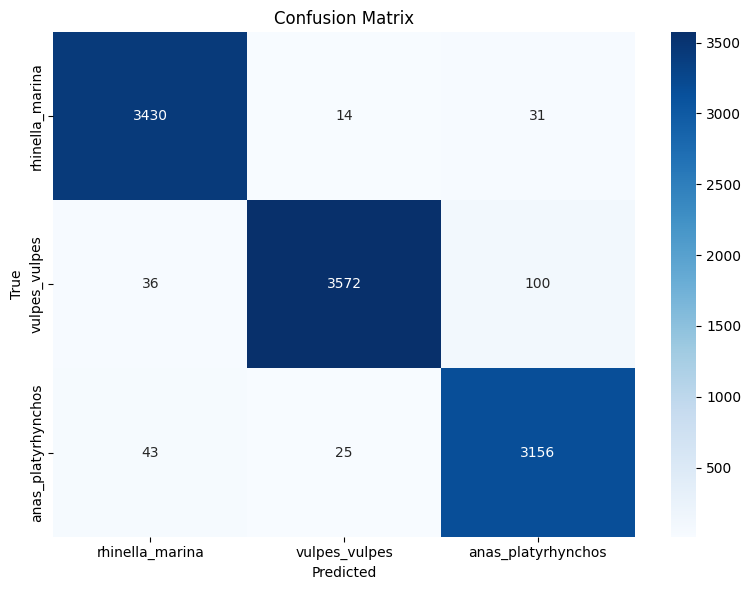

In [22]:
# Options: "resnet18", "mobilenet_v2", "efficientnet_b0"
model_name = "mobilenet_v2"  # or "efficientnet_b0", "resnet18"
model = get_model(model_name, num_classes)

# Train and evaluate as before
train_model(model, train_loader, val_loader, num_epochs=5)
y_true, y_pred = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(y_true, y_pred, class_names)


/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] Loss: 249.8147
Epoch [2/5] Loss: 105.1359
Epoch [3/5] Loss: 70.6119
Epoch [4/5] Loss: 50.1113
Epoch [5/5] Loss: 38.5550

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3475
           1       0.99      0.99      0.99      3708
           2       0.99      0.99      0.99      3224

    accuracy                           0.99     10407
   macro avg       0.99      0.99      0.99     10407
weighted avg       0.99      0.99      0.99     10407

Accuracy:  0.9912
Precision: 0.9911
Recall:    0.9912
F1 Score:  0.9911
AUC:       0.9997


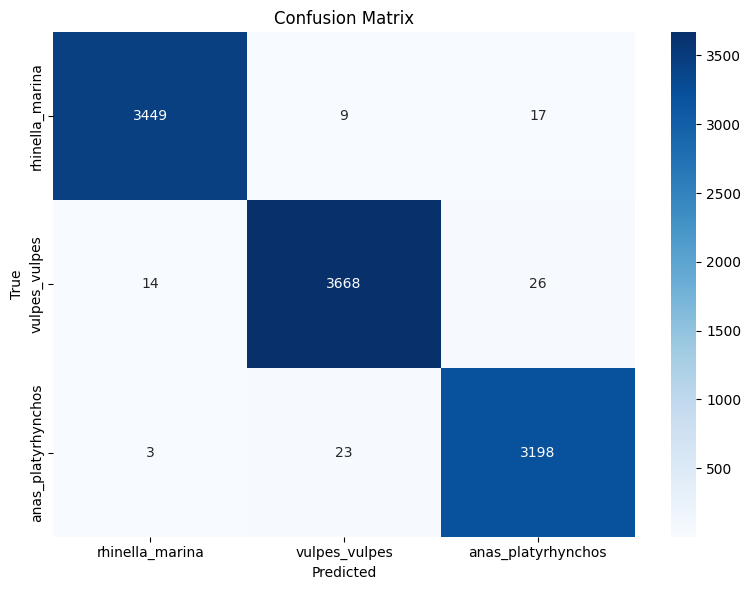

In [23]:
# Options: "resnet18", "mobilenet_v2", "efficientnet_b0"
model_name = "efficientnet_b0"  # or "efficientnet_b0", "resnet18"
model = get_model(model_name, num_classes)

# Train and evaluate as before
train_model(model, train_loader, val_loader, num_epochs=5)
y_true, y_pred = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(y_true, y_pred, class_names)


In [34]:
model = models.mobilenet_v2(pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Replace classifier with custom output (assuming 2 species → 2 classes)
num_classes = 3
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

model = model.to(device)

/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


In [37]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [38]:
def train_model(model, train_loader, val_loader, num_epochs=30):
    early_stopper = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)
        early_stopper(avg_val_loss, model)

        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load best weights
    model.load_state_dict(early_stopper.best_model_wts)
    return model


In [39]:
# Assuming already have train_loader and val_loader from earlier
trained_model = train_model(model, train_loader, val_loader, num_epochs=30)


Epoch [1/30], Train Loss: 0.1719, Val Loss: 0.1071
Epoch [2/30], Train Loss: 0.1002, Val Loss: 0.0918
Epoch [3/30], Train Loss: 0.0770, Val Loss: 0.0776
Epoch [4/30], Train Loss: 0.0612, Val Loss: 0.0699
Epoch [5/30], Train Loss: 0.0508, Val Loss: 0.0675
Epoch [6/30], Train Loss: 0.0439, Val Loss: 0.0579
Epoch [7/30], Train Loss: 0.0399, Val Loss: 0.0623
EarlyStopping counter: 1/5
Epoch [8/30], Train Loss: 0.0342, Val Loss: 0.0509
Epoch [9/30], Train Loss: 0.0327, Val Loss: 0.0526
EarlyStopping counter: 1/5
Epoch [10/30], Train Loss: 0.0283, Val Loss: 0.0515
EarlyStopping counter: 2/5
Epoch [11/30], Train Loss: 0.0308, Val Loss: 0.0491
Epoch [12/30], Train Loss: 0.0228, Val Loss: 0.0579
EarlyStopping counter: 1/5
Epoch [13/30], Train Loss: 0.0230, Val Loss: 0.0565
EarlyStopping counter: 2/5
Epoch [14/30], Train Loss: 0.0254, Val Loss: 0.0482
Epoch [15/30], Train Loss: 0.0193, Val Loss: 0.0458
Epoch [16/30], Train Loss: 0.0180, Val Loss: 0.1067
EarlyStopping counter: 1/5
Epoch [17/30], 

In [41]:
model.eval()  # Set to evaluation mode


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [42]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import numpy as np

def evaluate_on_test(model, test_loader, class_names):
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except:
        auc = float('nan')

    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    return all_labels, all_preds


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


Classification Report:

                    precision    recall  f1-score   support

   rhinella_marina       0.99      0.99      0.99      3475
     vulpes_vulpes       0.99      0.99      0.99      3708
anas_platyrhynchos       0.99      0.99      0.99      3224

          accuracy                           0.99     10407
         macro avg       0.99      0.99      0.99     10407
      weighted avg       0.99      0.99      0.99     10407

Accuracy:  0.9918
Precision: 0.9917
Recall:    0.9919
F1 Score:  0.9918
AUC:       0.9998


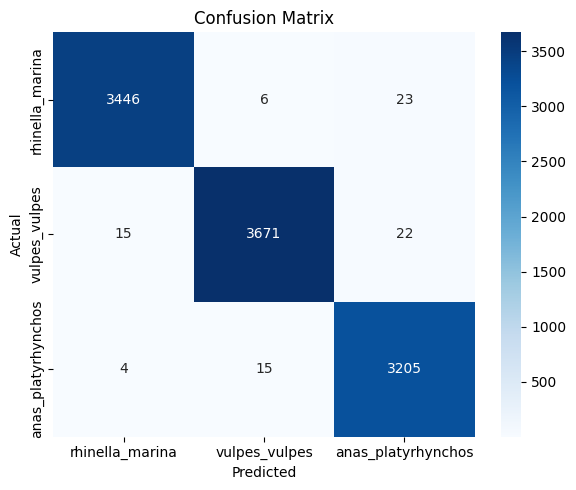

In [44]:

y_true, y_pred = evaluate_on_test(model, test_loader, class_names)
plot_confusion(y_true, y_pred, class_names)
